<a href="https://colab.research.google.com/github/Joshua-Woodard/Food_Vision_Big/blob/main/milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

Annotated version on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

* Google Colab offers free GPUs...
  * However... not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4... or if we are using our own hardware, our GPU needs a score of 7.0+
  * See here https://developer.nvidia.com/cuda-gpus

In [ ]:
!nvidia-smi -L # Can keep resetting the runtime until you get Tesla T4! ... can be a hassle

GPU 0: Tesla T4 (UUID: GPU-a1cd2561-95a9-1e26-46f0-a7eea3e9e77b)


## Get helper functions

Redownload previously created helper function!

In [ ]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-19 20:00:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-19 20:00:31 (63.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

Read the guide for tensorflow datasets online for more info!


In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list) # is our target dataset in the list?

True


In [ ]:
# Load in the data (can take 5-6 minutes in Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned as a tuple (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteW1H1ZQ/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteW1H1ZQ/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## 
Exploring the Food101 data from TensorFlow Datasets
Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the `.take()` method) and explore it.

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

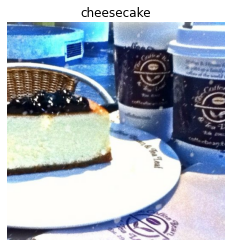

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural Networks perform best when data is in a certain way, eg. batched, normalized, etc.

However, not all data comes like this.

So in order to get it ready for a neural network, we'll need to write preprocessing functions and map it to the data.

> What we know about our data:

* in `uint8` datatype
* comprised of all different size tensors (images)
* not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or in mixed precision `float16` or `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (or normalized eg between 0 & 1) generally perform better.

With these things in mind, we've got a few things we can tackle with a preprocessing function! 🙂


Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications, we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`


In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `unint8` -> `float32` and reshapes image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image anc check the output
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batching and preparing our dataset ( to make it run fast! )

We're now going to make our data input pipeline run really fast.

For more resources on this, see the guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # Autotune used here allows tf to use as many processors as it can find (to run in PARALLEL)
# Shuffle train_data and turn it into batches and prefetch it (load it faster!)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # autotune here allows tf to prepare as many batches as it can in the CPU to be computed on GPU

#Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

To help visualize prefetching... see the following graphic -> https://canvas.education.lu.se/users/9031/files/448101/preview?verifier=yGvFUdX8pk62i7b5WDAqKbWCDH4OUxOIuDxu6jyP

## Creating Modeling Callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if needed)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (imported from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create modelcheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup Mixed Precision Training

First and foremost, for a deeper understanding of mixed precision training, check out the TF guide here: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX has rescaling built in. if it doesn't, use the code below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # make sure layers which should be in inference modoe only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision)?

In [ ]:
# Check the dtype_policy attriubutes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? If `False` the weights are frozen.
* `layer.dtype`: the datatype a layer stores its variables in
* `layer.dtype_policy`: the datatype policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in base_model
for layer in model.layers[1].layers: # check the layers of the base model at index 1 of model
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of things is:
1. Build a feature extraction model (traina couple output layers with base layers frozen
2. Fine-tune some of the frozen layers

In [ ]:
# Fit model
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220519-200825
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8196 - accuracy: 0.5578WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 189s 72ms/step - loss: 1.8196 - accuracy: 0.5578 - val_loss: 1.2343 - val_accuracy: 0.6716
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2920 - accuracy: 0.6660WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 172s 72ms/step - loss: 1.2920 - accuracy: 0.6660 - val_loss: 1.1172 - val_accuracy: 0.6999
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1425 - accuracy: 0.7032WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 166s 70ms/step - loss: 1.1425 - accuracy: 0.7032 - val_loss: 1.0889 - val_accuracy: 0.7074


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 55s 70ms/step - loss: 1.0884 - accuracy: 0.7093


[1.0884417295455933, 0.7093465328216553]

## Save the whole model to file

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save("drive/My Drive/Models/Food_Vision_Big/food_vision_big_model1")

INFO:tensorflow:Assets written to: drive/My Drive/Models/Food_Vision_Big/food_vision_big_model1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Models/Food_Vision_Big/food_vision_big_model1/assets


In [ ]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model("drive/My Drive/Models/Food_Vision_Big/food_vision_big_model1")

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_model.layers:
  print(layer.dtype_policy)

<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "float32">


In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 1.0884 - accuracy: 0.7093


In [ ]:
results_feature_extract_model

[1.0884417295455933, 0.7093465328216553]

In [ ]:
import numpy as np
np.isclose(results_loaded_model, results_feature_extract_model)

array([ True,  True])

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 


## Preparing our model's layers for fine-tuning

**Next:** Fine-tune the feature extraction model to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf).

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-05-19 20:22:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  62.1MB/s    in 0.3s    

2022-05-19 20:22:28 (62.1 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
downloaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the downloaded model
downloaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
downloaded_gs_model.evaluate(test_data)

790/790 [==============================] - 53s 64ms/step - loss: 1.0881 - accuracy: 0.7065


[1.0881284475326538, 0.7064950466156006]

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in downloaded_gs_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in downloaded_gs_model.layers:
  print(layer.dtype_policy)

<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "float32">


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more

checkpoint_filepath = "downloaded_gs_model_checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               monitor="val_loss",
                                                               save_best_only=True)


In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
downloaded_gs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                            metrics=["accuracy"])


In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
history_downloaded_gs_model_1 = downloaded_gs_model.fit(train_data,
                                                        epochs=100,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15*len(test_data)),
                                                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                               experiment_name="downloaded_gs_model_big_food_vision"),
                                                                   model_checkpoint_callback,
                                                                   early_stopping_callback,
                                                                   reduce_lr])


Saving TensorBoard log files to: training_logs/downloaded_gs_model_big_food_vision/20220519-202541
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9225 - accuracy: 0.7525INFO:tensorflow:Assets written to: downloaded_gs_model_checkpoint/assets


INFO:tensorflow:Assets written to: downloaded_gs_model_checkpoint/assets


2368/2368 [==============================] - 397s 161ms/step - loss: 0.9225 - accuracy: 0.7525 - val_loss: 0.8211 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.8387INFO:tensorflow:Assets written to: downloaded_gs_model_checkpoint/assets


INFO:tensorflow:Assets written to: downloaded_gs_model_checkpoint/assets


2368/2368 [==============================] - 384s 161ms/step - loss: 0.5794 - accuracy: 0.8387 - val_loss: 0.7811 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 342s 144ms/step - loss: 0.3304 - accuracy: 0.9061 - val_loss: 0.8405 - val_accuracy: 0.7892 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9482
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 337s 141ms/step - loss: 0.1749 - accuracy: 0.9482 - val_loss: 0.9200 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.0362 - accuracy: 0.9918 - val_loss: 1.0275 - val_accuracy: 0.8085 - lr: 2.0000e-05


In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
downloaded_gs_model.save("drive/My Drive/Models/downloaded_gs_model_big_food_vision")

INFO:tensorflow:Assets written to: drive/My Drive/Models/downloaded_gs_model_big_food_vision/assets


INFO:tensorflow:Assets written to: drive/My Drive/Models/downloaded_gs_model_big_food_vision/assets


In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
downloaded_loss, downloaded_acc = downloaded_gs_model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 1.0363 - accuracy: 0.8005


## View training results on TensorBoard

**To do:** Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.


In [ ]:
import tensorflow as tf

In [ ]:
!tensorboard dev upload --logdir "training_logs/downloaded_gs_model_big_food_vision" \
    --name "Big_Food_Vision_1" \
    --description "First attempt at Big Food Vision model"


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

training_logs/downloaded_gs_model_big_food_vision

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=nRdAZ1VCsTgEncw13vdTJtiUWCSrA

## Evaluate your trained model

Some ideas you might want to go through:
1. Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes.
3. Find your model's *most wrong* predictions (those with the highest prediction probability but the wrong prediction).

See the evaluation section at the end of [Transfer Learning Part 3: Scaling Up for more](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb).

In [ ]:
pred_probs = downloaded_gs_model.predict(test_data, verbose=1)

790/790 [==============================] - 52s 63ms/step


In [ ]:
pred_probs[:10]

array([[1.2359710e-10, 1.0851780e-05, 6.7481731e-09, ..., 1.0527461e-12,
        1.2607248e-08, 5.0937885e-09],
       [3.1433920e-12, 1.4996284e-11, 1.3584637e-06, ..., 1.6283175e-09,
        9.9670863e-01, 8.3291593e-13],
       [4.9399162e-11, 7.6075279e-10, 2.4839459e-11, ..., 2.7594146e-13,
        1.5216013e-10, 1.9845424e-10],
       ...,
       [1.5730899e-07, 1.6650108e-06, 5.5220646e-08, ..., 3.3352479e-10,
        2.2662507e-08, 8.6017176e-09],
       [7.5135080e-12, 5.3955087e-06, 1.5264617e-12, ..., 2.2627662e-18,
        3.9202780e-13, 1.8154489e-15],
       [1.8937041e-14, 2.0948883e-18, 3.2495142e-21, ..., 1.8699662e-20,
        5.0389602e-13, 4.1188748e-16]], dtype=float32)

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[0].sum()

1.0

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
pred_classes[:10]

array([37, 99, 40, 60,  1, 69, 52, 62, 77, 67])

In [ ]:
y_label = []
y_label = np.concatenate([y for x, y in test_data], axis=0) 
y_label.shape

(25250,)

In [ ]:
y_label[90], pred_classes[90]

(23, 99)

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [ ]:
labels = get_labels_from_tfdataset(test_data)


In [ ]:
labels

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([ 3, 73, 22, ..., 76, 31, 21])>

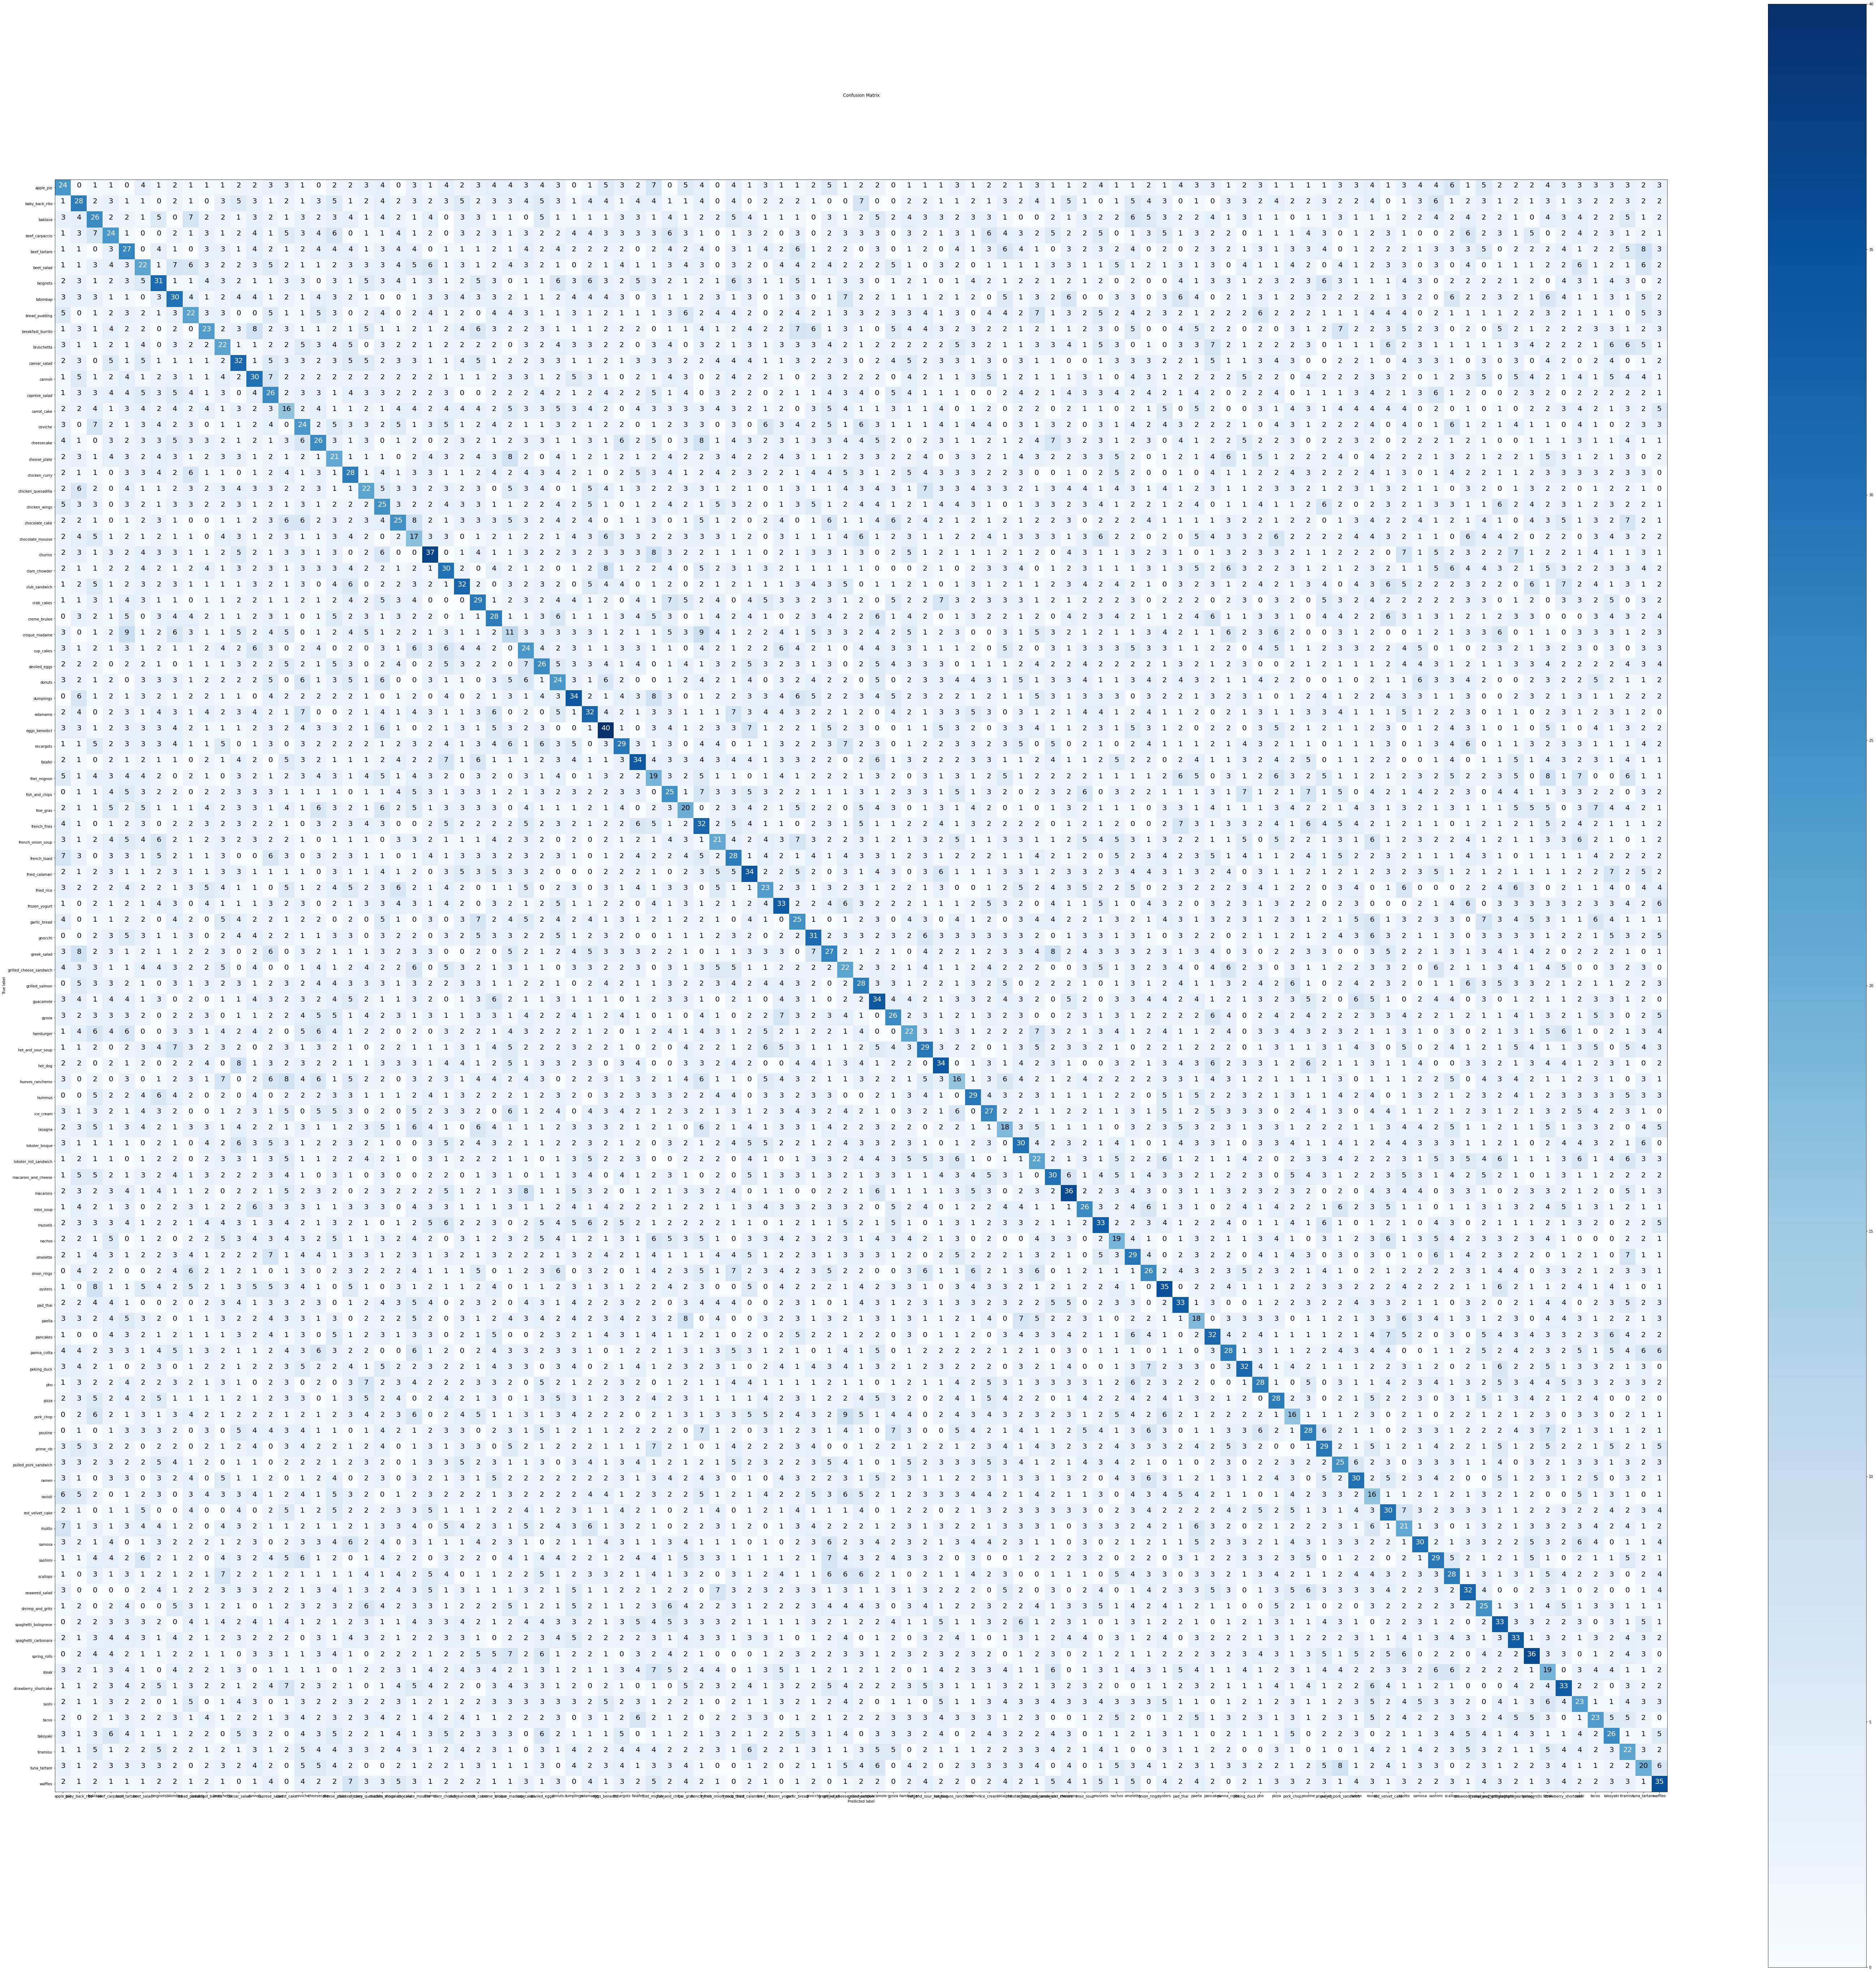

In [ ]:
make_confusion_matrix(y_true=labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       250
           1       0.12      0.11      0.12       250
           2       0.10      0.10      0.10       250
           3       0.10      0.10      0.10       250
           4       0.10      0.11      0.10       250
           5       0.09      0.09      0.09       250
           6       0.12      0.12      0.12       250
           7       0.12      0.12      0.12       250
           8       0.10      0.09      0.09       250
           9       0.11      0.09      0.10       250
          10       0.09      0.09      0.09       250
          11       0.12      0.13      0.13       250
          12       0.12      0.12      0.12       250
          13       0.10      0.10      0.10       250
          14       0.06      0.06      0.06       250
          15       0.09      0.10      0.09       250
          16       0.11      0.10      0.11       250
          17       0.08    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.09856262833675565,
  'precision': 0.10126582278481013,
  'recall': 0.096,
  'support': 250},
 '1': {'f1-score': 0.1154639175257732,
  'precision': 0.11914893617021277,
  'recall': 0.112,
  'support': 250},
 '10': {'f1-score': 0.09034907597535934,
  'precision': 0.09282700421940929,
  'recall': 0.088,
  'support': 250},
 '100': {'f1-score': 0.13944223107569723,
  'precision': 0.1388888888888889,
  'recall': 0.14,
  'support': 250},
 '11': {'f1-score': 0.12648221343873517,
  'precision': 0.125,
  'recall': 0.128,
  'support': 250},
 '12': {'f1-score': 0.11857707509881422,
  'precision': 0.1171875,
  'recall': 0.12,
  'support': 250},
 '13': {'f1-score': 0.10077519379844961,
  'precision': 0.09774436090225563,
  'recall': 0.104,
  'support': 250},
 '14': {'f1-score': 0.06387225548902195,
  'precision': 0.06374501992031872,
  'recall': 0.064,
  'support': 250},
 '15': {'f1-score': 0.09248554913294797,
  'precision': 0.08921933085501858,
  'recall': 0.096,
  'support': 

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.09856262833675565,
 'baby_back_ribs': 0.1154639175257732,
 'baklava': 0.10441767068273092,
 'beef_carpaccio': 0.09677419354838711,
 'beef_tartare': 0.1036468330134357,
 'beet_salad': 0.0901639344262295,
 'beignets': 0.12350597609561752,
 'bibimbap': 0.11976047904191617,
 'bread_pudding': 0.09421841541755888,
 'breakfast_burrito': 0.10176991150442477,
 'bruschetta': 0.09034907597535934,
 'caesar_salad': 0.12648221343873517,
 'cannoli': 0.11857707509881422,
 'caprese_salad': 0.10077519379844961,
 'carrot_cake': 0.06387225548902195,
 'ceviche': 0.09248554913294797,
 'cheese_plate': 0.08030592734225621,
 'cheesecake': 0.10526315789473684,
 'chicken_curry': 0.11111111111111109,
 'chicken_quesadilla': 0.0918580375782881,
 'chicken_wings': 0.09560229445506693,
 'chocolate_cake': 0.10593220338983052,
 'chocolate_mousse': 0.06513409961685825,
 'churros': 0.14595660749506903,
 'clam_chowder': 0.11904761904761904,
 'club_sandwich': 0.12877263581488932,
 'crab_cakes': 0.11372549019

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
34,eggs_benedict,0.156250
92,spring_rolls,0.146341
23,churros,0.145957
63,macarons,0.144578
55,hot_dog,0.140496
...,...,...
56,huevos_rancheros,0.065708
22,chocolate_mousse,0.065134
14,carrot_cake,0.063872
82,ravioli,0.059813


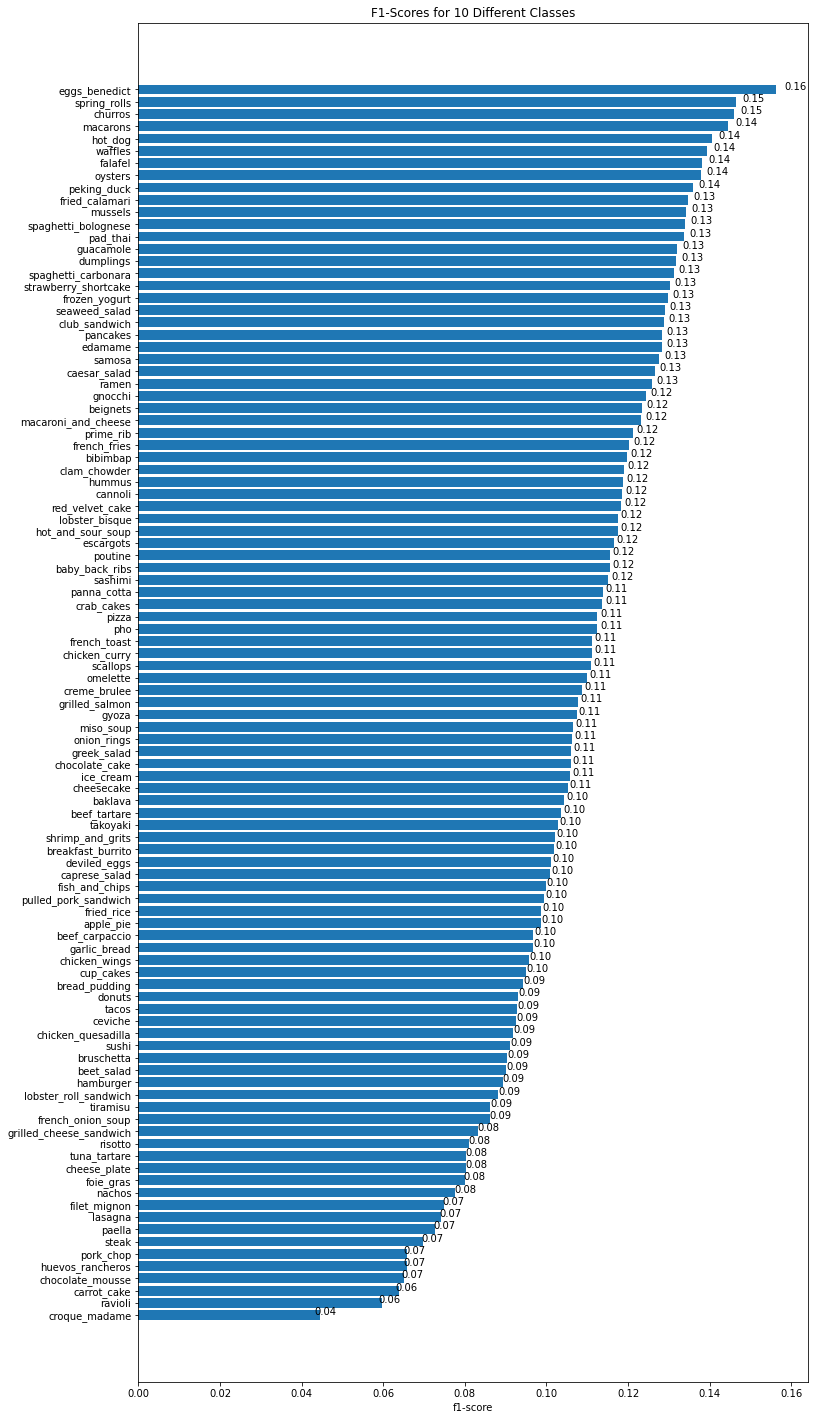

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## 📖 Extra-curriculum

* Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler). What is it? And how might it be helpful to this project?
* Read up on TensorFlow data loaders ([improving TensorFlow data loading performance](https://www.tensorflow.org/guide/data_performance)). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
* Read up on the documentation for [TensorFlow mixed precision training](https://www.tensorflow.org/guide/mixed_precision). What are the important things to keep in mind when using mixed precision training?